In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [112]:
# To use torch in python.
import torch

# To create a model by layers.
import torch.nn as nn
import torch.nn.functional as F

# To set the optimization.
import torch.optim as optim
from torch.optim import lr_scheduler

# To manipulate arrays.
import numpy as np

# To save the best model and get data files.
import os
import copy

import time
import pywt
import math
import pandas as pd
import seaborn as sns
import matplotlib.colors
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LBE
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Keras 
import tensorflow
from keras import layers as L
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer

# Torch
import torch
from torch.optim import Adam
from torch.nn.modules.activation import ReLU
from torch.utils.data import TensorDataset, DataLoader

# location of patient data on drive to be used as train / val / test
root = '/content/drive/My Drive/UW/AI_healthcare/Mini-project-1/data/'

In [3]:
# Load the csv files over here into pandas data frame
# 0.1
def load_csv(folder,file):
    return pd.read_csv(os.path.join(folder,file))

def normalizer(X):
    scalar = StandardScaler()
    return scalar.fit_transform(X)

# Exercise 1

In [127]:
def preprocessor(folder):
    # Input: List of all csv and txt files.
    # Output: Single dataframe containing entire data.
    # It is best to keep functions short(20 lines max), so feel free to use helper functions here.
    columns=['Timestamp','Sample#','Type','Sub', 'Chan','Num_Aux','None']
    files=os.listdir(folder)
    data=[]
    annotation=[]
    filename=[]
    for file in files:
        if('.csv' in file):
            
            df_person = load_csv(folder,file)
            
            df_person=df_person.rename(columns={df_person.columns[0]: "Sample#", df_person.columns[1]: df_person.columns[1].replace('\'',''), df_person.columns[2]: df_person.columns[2].replace('\'','')})
            df_annotation = pd.read_csv(os.path.join(folder,file.split('.')[0]+'annotations.txt'), delimiter=r"\s+",names=columns,skiprows=1,usecols = columns[:-1],engine='python')
            df_annotation.loc[(df_annotation['Type']!='N') & (df_annotation['Type']!='L') & (df_annotation['Type']!='R') & (df_annotation['Type']!='A') & (df_annotation['Type']!='V'),'Type' ]='U'
            df_annotation['Sample#']=df_annotation['Sample#'].astype(int)
            
            df_annotation['left']=df_annotation['Sample#'] - df_annotation['Sample#'].shift(1)
            df_annotation['right']=abs(df_annotation['Sample#'] - df_annotation['Sample#'].shift(-1))
            df_annotation=df_annotation[(df_annotation['Sample#']>=180) &  (df_person.shape[0]-df_annotation['Sample#']>=180)]
            data.append(df_person)
            annotation.append(df_annotation)
            filename.append(file)

    return data, annotation,filename

def create_features(data_person,annotation_person,feature_no=360):
    
    df_features=pd.DataFrame({'Sample#':annotation_person['Sample#'].values,
                              'Type':annotation_person['Type'].values})
    df_features=df_features.merge(data_person[['Sample#']],on='Sample#')
    data_person['MLII_normal']=normalizer(np.array(data_person['MLII'].values)[:, np.newaxis])

    feature=[]
    column=[]
    for i in np.arange(-180,180):
        if(i==0):
            column.append('MLII')
        elif(i<0):
            column.append('Left'+str(abs(i)))
        else:
            column.append('right'+str(abs(i)))
    for sample in df_features['Sample#']:
        feature.append(data_person[(data_person['Sample#']>=sample-180) & (data_person['Sample#']<=sample+179)]['MLII_normal'].values)
    df_feature=pd.DataFrame(data=feature,columns=column)
    df = pd.concat([df_features,df_feature],axis=1)
    if(feature_no==720):
        df_features2=pd.DataFrame({'Sample#':df_features['Sample#'].values})
        data_person['V1_normal']=normalizer(np.array(data_person['V1'].values)[:, np.newaxis])

        feature=[]
        column=[]
        for i in np.arange(-180,180):
            if(i==0):
                column.append('V1')
            elif(i<0):
                column.append('V1-Left'+str(abs(i)))
            else:
                column.append('V1-right'+str(abs(i)))

        for sample in df_features['Sample#']:
            feature.append(data_person[(data_person['Sample#']>=sample-180) & (data_person['Sample#']<=sample+179)]['V1_normal'].values)
        df_feature2=pd.DataFrame(data=feature,columns=column)
        df_feature2['Sample#']=df_features['Sample#'].values
        return df.merge(df_feature2,on='Sample#')
    else:
        return df

In [158]:
'''
Functions for quickly plotting one sample to visualize
'''
# Call this function when sample is from a dataframe
def quick_plot(sample):
  plt.plot(np.arange(len(sample.values)), sample.values)
  plt.show()

# Call this function when the sample is from an array
def quick_plot_ar(sample, title=None):
  plt.plot(np.arange(len(sample)), sample)
  if title != None:
    plt.title(title)
  plt.show()

'''
Function for plotting 3 of each class
'''
def plotting(df,person,min=0,max=1000,type_plot='range'):
  # Plot a few heartbeats here with proper labelling.
    #plt.figure(1)
    if(type_plot=='range'):
        df_person=df[df['Person']==person]
        for sample,value,heart_type in zip(df_person['Sample#'],df_person['MLII'],df_person['Type']):
            if(sample<=max and sample>=min):
                y=df_person[df_person['Sample#']==sample].drop(['Sample#','Type','Person'],axis=1).values.flatten()
                x=np.arange(sample-180,sample+180)
                plt.plot(x,y,'b')
                plt.annotate(heart_type,(sample,value),textcoords="offset points", xytext=(0,10),ha='center')
        #plt.show()
        plt.xlim([min,max])
    if(type_plot=='label'):
        N_type=df[df['Type']=='N'].iloc[np.random.randint(low=0,high=df[df['Type']=='N'].shape[0],size=3)]
        
        for row in range(0,3):
            plt.figure(row)
            plt.plot(N_type.iloc[[row]].drop(['Sample#','Type','Person'],axis=1).values[0])
                     #/np.amax(N_type.iloc[[row]].drop(['Sample#','Type','Person'],axis=1).values[0]))
            person = N_type.iloc[[row]]['Person'].values[0]
            sample = N_type.iloc[[row]]['Sample#'].values[0]
            plt.title(f'Heart Type = N for person {person} and sample {sample}')

        type_class=['A','A','A','V','V','V','L','L','L','R','R','R','U','U','U']

        heart_class=[]
        for row,heart in enumerate(type_class):
            plt.figure(row+4)
            location = np.random.randint(low=0,high=df[df['Type']==heart].shape[0],size=1)
            plt.plot(df[df['Type']==heart].drop(['Sample#','Type','Person'],axis=1).iloc[location].values[0])
                    #/np.amax(df[df['Type']==heart].drop(['Sample#','Type','Person'],axis=1).iloc[np.random.randint(low=0,high=df[df['Type']==heart].shape[0],size=1)].values[0]))
            person = df[df['Type']==heart].iloc[location]['Person'].values[0]
            sample = df[df['Type']==heart].iloc[location]['Sample#'].values[0]
            plt.title(f'Heart Type = {heart} for person {person} and sample {sample}')
            

In [184]:

data,annotations,filename=preprocessor(root)

df=pd.DataFrame()
for i in range(0,len(data)):
    if('MLII' in data[i].columns):
        df_person = create_features(data[i],annotations[i])
        df_person['Person']=filename[i].split('.')[0]
        if(i==0):
            df=df_person
        else:
            df=pd.concat([df,df_person],axis=0)
    else:
        print(f'MLII not present in {filename[i]}')

df.to_csv(root[:-5] + 'dataframe.csv', index=False) # save the df

MLII not present in 102.csv
MLII not present in 104.csv


Shape of dataframe after preprocessing: (98312, 363)




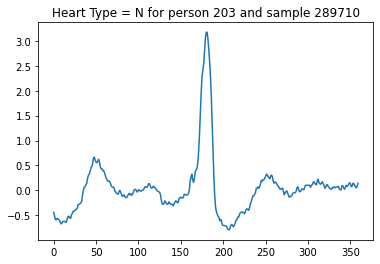

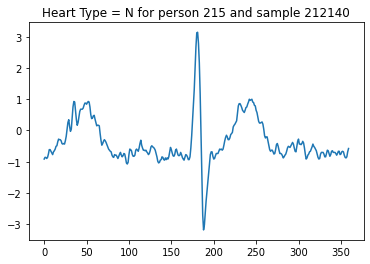

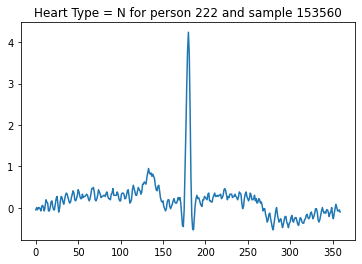

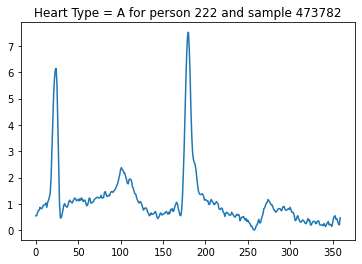

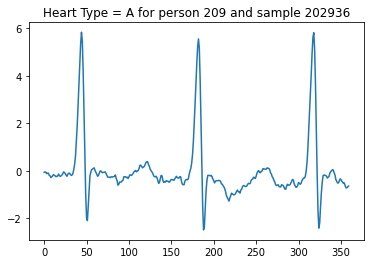

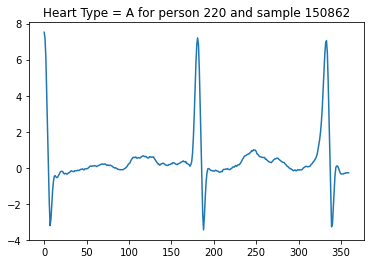

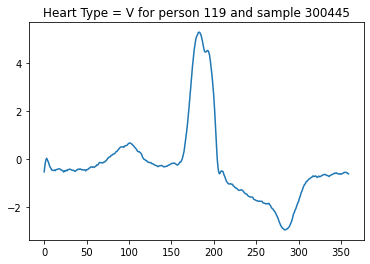

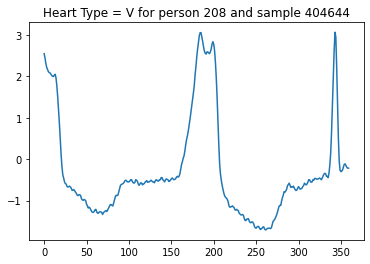

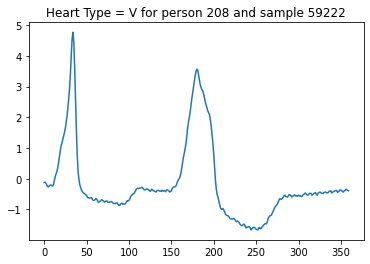

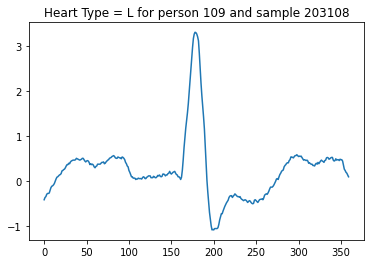

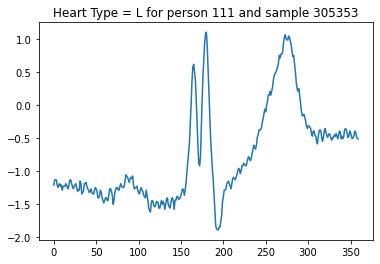

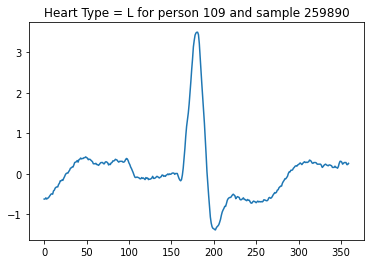

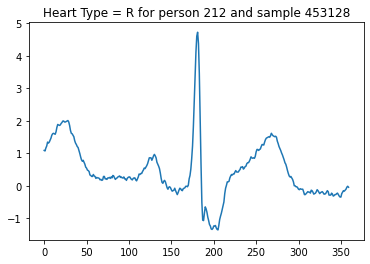

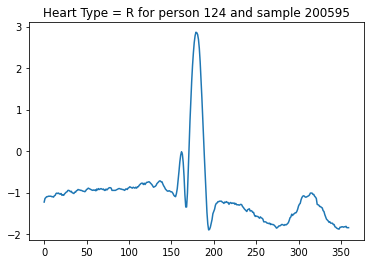

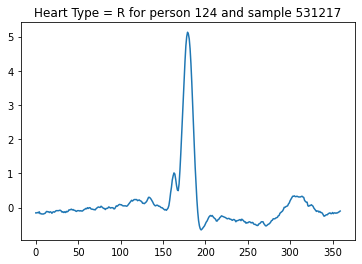

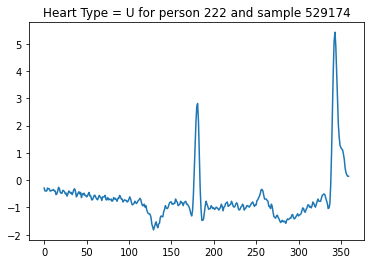

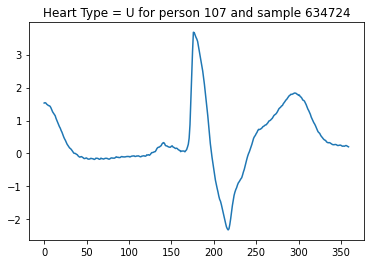

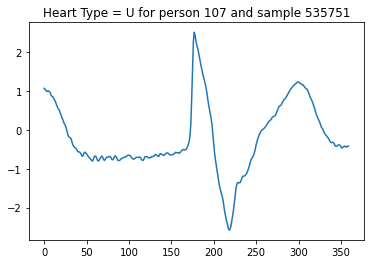

In [6]:
# load dataframe
df = load_csv(root[:-5], 'dataframe.csv')

# Print length of dataframe you got after preprocessing.
print(f'Shape of dataframe after preprocessing: {df.shape}\n\n')

# plot the graphs for these indices
plotting(df,person=str(230),min=0,max=5000,type_plot='label')

# Exercise 2

In [ ]:
'''
After analyzing the data, we decided not to do any outlier removal or other cleaning  steps 
not mentioned in the code  /report as  the heartbeats are very variable and in an  effort to  
remove  outliers we may actually end up removing good data.
'''
def cleaning(df_in):
  # Take all the features as input, and do any data cleaning necessary.
  pass

# Exercise 3

Classes have the below balance: 
class N: 69507 samples. ( 70.700%)
class L: 8071 samples. ( 8.210%)
class R: 5605 samples. ( 5.701%)
class A: 1156 samples. ( 1.176%)
class V: 6288 samples. ( 6.396%)
class U: 7685 samples. ( 7.817%)


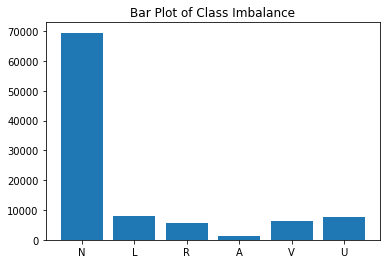

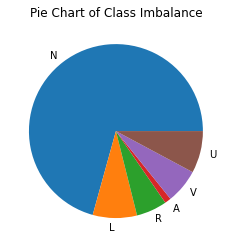

In [7]:
def class_imbalance_checker(df_in, print_out=False):
  # Print number of rows with each heartbeat type, along with plots to represent it.
  valid_labels = ['N', 'L', 'R', 'A', 'V', 'U'] # set of valid labels
  class_numbers = []
  class_percentages = []
  if print_out: print('Classes have the below balance: ')
  for v in valid_labels:
    num_class = df_in[df_in["Type"] == v].shape[0]
    class_numbers.append(num_class)
    class_percentages.append(num_class/df_in.shape[0] * 100)
    if print_out: print(f'class {v}: {num_class} samples. ({num_class/df_in.shape[0] * 100 : .3f}%)')

  if print_out:
    plt.bar(valid_labels, class_numbers)
    plt.title('Bar Plot of Class Imbalance')
    plt.show()

    plt.pie(class_percentages, labels=valid_labels)
    plt.title('Pie Chart of Class Imbalance')
    plt.show()

  return class_numbers, valid_labels

want = True

if want:
  df = load_csv(root[:-5], 'dataframe.csv')
  count_classes, valid_labels = class_imbalance_checker(df, print_out=True)

In [8]:
# Splitting the dataset into train, val and test sets.
# 2.0
def tts(X,y, test_size=0.2):
  return train_test_split(X, y, test_size = test_size)

In [31]:
'''
Helper Function to generate columns names of dataframes
'''
def get_col_names():
  cols = []
  for i in range(180,0,-1):
    cols.append('Left'+str(i))
  cols.append('MLII')
  for i in range(1,180):
    cols.append('right'+str(i))
  cols.append('Type')
  return cols

'''
Function that returns the labels of classes that need more samples and the counts of the classes
'''
def get_classes_need_more(df_in, upsample_to):
  count_classes, valid_labels = class_imbalance_checker(df_in) # get the class counts and the labels from the class_imbalance checker
  classes_need_more, counts = [],[] # two empty lists
  for count, label in zip(count_classes, valid_labels): # iterate the classes
    to_add = upsample_to - count # get the number of samples to add
    if to_add > 0: # if there are samples to add
      classes_need_more.append(label) # append the class label that needs more samples
      counts.append(count) # append the current number of samples
  return classes_need_more, counts # return the two constructed lists

'''
Autoencoder architecture and training function -- saves the best model to drive
'''
def AE_arch(samples_x, label, train_again):
  # AE Architecture
  input_sample = Input(shape=(360,))
  e1 = Dense(100, activation='relu') (input_sample)
  encoded = Dense(100, activation='relu') (e1)
  d1 = Dense(100, activation='relu') (encoded)
  decoded = Dense(360) (d1)
  # Model Creation
  autoencoder = Model(input_sample, decoded)
  encoder = Model(input_sample, encoded)
  decoder = Model(encoded, decoded)
  # Train AE
  autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  
  # Split the samples for train and val sets
  if train_again:  
    X_train_samples = samples_x[:int(len(samples_x)*0.8)]
    X_val_samples = samples_x[int(len(samples_x)*0.8):]
    # Save the best model based on validation loss
    model_name_loss = root[:-5] +'AE_loss_'+label+'.h5'
    chkpoint = ModelCheckpoint(filepath=model_name_loss, 
                                monitor='val_loss',
                                verbose=0, 
                                save_best_only=True,
                                mode='min')
    callbacks = [chkpoint]

    # train the AE
    autoencoder.fit(X_train_samples, X_train_samples, epochs=100, batch_size=32, shuffle=False, validation_data=(X_val_samples, X_val_samples), callbacks=callbacks, verbose=0)

  return autoencoder, encoder, decoder

'''
Function that calls the ae arch function, trains and generates a list of new signals for one class 
'''
def AE_generate_by_class(samples, number_to_generate, label, train_again):
  new_signals = []
  print(f'Training AE for class {label}', end='...')
  AE, E, D = AE_arch(samples, label, train_again) # build and train AE
  print('completed')
  
  AE.load_weights(root[:-5] +'AE_loss_'+label+'.h5') # load the best model
  encoded_samples = E.predict(samples) # generate the encoded signal 

  print(f'   Generating at least {number_to_generate} new samples... from {encoded_samples.shape}', end='...')
  while len(new_signals) < number_to_generate:
    encoded_noise = encoded_samples + np.random.normal(0.0, 0.1, size=(encoded_samples.shape)) # add random noise to each sample
    news = D.predict(encoded_noise)
    del(encoded_noise)
    labels = []
    for i in range(len(news)):
      labels.append(label)
    new_signals.extend(np.c_[np.array(news), np.array(labels)])
    del(news)
  
  print(f'completed, generated {len(new_signals)} samples for class {label}')
  return new_signals

'''
Function that uses the above helper functions to generate a df of new samples
'''
def AE_imbalance(train_again=True):
  # load the data frome into ram, remove target for tts
  print('Loading Dataframe')
  df = load_csv(root[:-5], 'dataframe.csv')
  target = df.pop('Type')
  _ = df.pop('Person')
  _ = df.pop('Sample#')

  print('Splitting Dataframe into train/val/test')
  # split the data into train, val and test before data generation
  X, X_test, y, y_test = tts(df, target, test_size=0.1)
  X_train, X_val, y_train, y_val = tts(X, y, test_size=0.15)

  # add targets back to the dfs
  X_train['Type'] = y_train
  X_val['Type'] = y_val
  X_test['Type'] = y_test

  # Save the dfs
  print('Saving train/val/test dataframes')
  X_train.to_csv(root[:-5] + 'modded/X_train.csv', index=False)
  X_val.to_csv(root[:-5] + 'modded/X_val.csv', index=False)
  X_test.to_csv(root[:-5] + 'modded/X_test.csv', index=False)

  # Clean up RAM
  del(df)

  upsample_to = len(X_train[X_train['Type']=='N'])/2

  # make use of an AE arch to adjust class imbalance
  labels, counts = get_classes_need_more(X_train, upsample_to) # get the classes that need more samples
  additional_samples = []
  for label, count in zip(labels, counts): # iterate the classes that need more samples
    samples = X_train[X_train['Type'] == label] # get the samples in the df of the target class
    _ = samples.pop('Type') # remove the target
    add = AE_generate_by_class(samples, upsample_to - count, label, train_again)
    df_additional = pd.DataFrame(data=add, columns=get_col_names()) # construct a df of the generated samples
    df_additional.to_csv(root[:-5] + 'more_data_by_class/' + label + '.csv', index=False)
    del(add)
    del(df_additional)

  # Load each new generated sample data in
  print('Loading in all generated dataframes to concat')
  og_data = load_csv(root[:-5], 'modded/X_train.csv') # load the original 
  A = load_csv(root[:-5], 'more_data_by_class/A.csv') # load the A df
  R = load_csv(root[:-5], 'more_data_by_class/R.csv') # load the R df
  L = load_csv(root[:-5], 'more_data_by_class/L.csv') # load the L df
  U = load_csv(root[:-5], 'more_data_by_class/U.csv') # load the U df
  V = load_csv(root[:-5], 'more_data_by_class/V.csv') # load the V df

  data = [og_data,A,L,R,U,V]
  X_train = pd.concat(data)
  print('mega train dataframe generated... saving to drive')
  X_train.to_csv(root[:-5] + 'modded/X_train_more_samples.csv', index=False)

  # separate to return
  y_train = X_train.pop('Type')
  y_val = X_val.pop('Type')
  y_test = X_test.pop('Type')

  return X_train, y_train, X_val, y_val, X_test, y_test


Loading Dataframe
Splitting Dataframe into train/val/test
Saving train/val/test dataframes
Training AE for class L...completed
   Generating at least 20406.5 new samples... from (6180, 100)...completed, generated 24720 samples for class L
L class generated 18540 samples
Training AE for class R...completed
   Generating at least 22327.5 new samples... from (4259, 100)...completed, generated 25554 samples for class R
R class generated 21295 samples
Training AE for class A...completed
   Generating at least 25711.5 new samples... from (875, 100)...completed, generated 26250 samples for class A
A class generated 25375 samples
Training AE for class V...completed
   Generating at least 21809.5 new samples... from (4777, 100)...completed, generated 23885 samples for class V
V class generated 19108 samples
Training AE for class U...completed
   Generating at least 20642.5 new samples... from (5944, 100)...completed, generated 23776 samples for class U
U class generated 17832 samples
Loading in

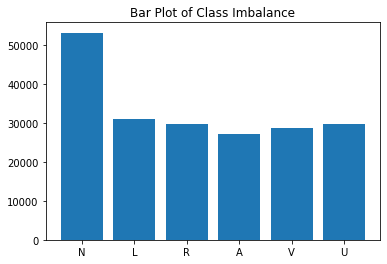

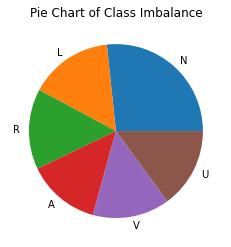

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = AE_imbalance()
X_train['Type'] = y_train
_, _ = class_imbalance_checker(X_train, print_out=True)
y_train = X_train.pop('Type')

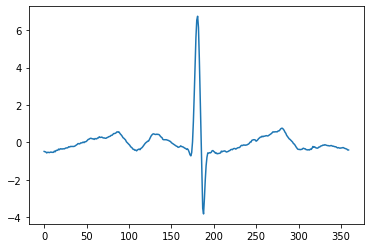

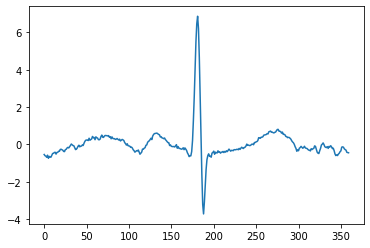

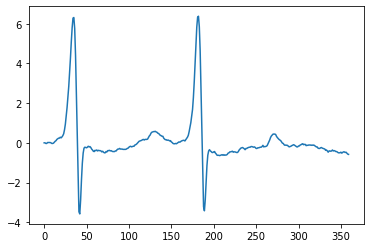

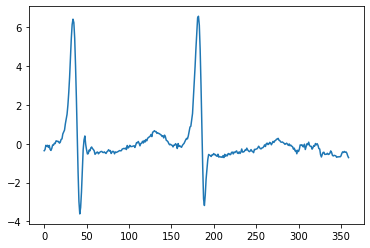

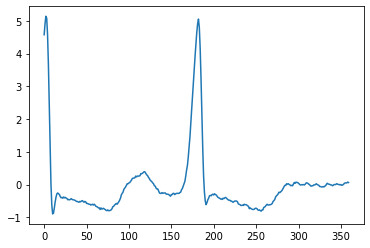

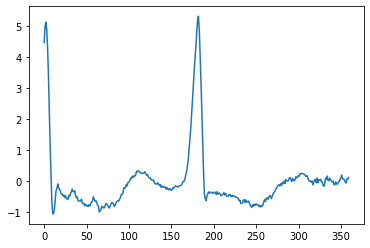

In [38]:
og_data = load_csv(root[:-5], 'modded/X_train.csv') # load the original 
A = load_csv(root[:-5], 'more_data_by_class/A.csv') # load the A df

og_A = og_data[og_data['Type']=='A']

_ = A.pop('Type')
_ = og_A.pop('Type')

samp = 32
quick_plot(og_A.iloc[samp])
quick_plot(A.iloc[samp])

samp = 160
quick_plot(og_A.iloc[samp])
quick_plot(A.iloc[samp])

samp = 67
quick_plot(og_A.iloc[samp])
quick_plot(A.iloc[samp])

In [136]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]
        y = self.labels[index]
        return X, y

def samples_to_generate(data,class_type='A',test_data_size=0.2):
    index=data.groupby(['Type']).count().index
    loc=np.where(index==class_type)[0]
    max_train_size=max(data.groupby(['Type']).count()['Sample#'].values)*(1-test_data_size)
    max_test_size=max(data.groupby(['Type']).count()['Sample#'].values)*(test_data_size)
    class_size = data.groupby(['Type']).count()['Sample#'].values[loc]
    if(class_size<max_test_size):
        return math.floor(max_train_size)

def class_to_augment(df,class_type):
  df_class=df[df['Type']==class_type]
  data = df_class.drop(['Type', 'Sample#', 'Person'],axis=1)
  return data

def create_X(df,class_type):
  X = class_to_augment(df,class_type).values
  y = (np.full((X.shape[0],1),0).tolist())
  return X,y

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        self.sigmoid = nn.Sigmoid()
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        h_       = self.ReLU(self.FC_input(x))
        h_       = self.ReLU(self.FC_input2(h_))
        mean     = (self.FC_mean(h_))
        log_var  = (self.FC_var(h_))                     # encoder produces mean and log of variance 
                                                                        # (i.e., parateters of simple tractable normal distribution "q"
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        h     = self.ReLU(self.FC_hidden(x))
        h     = self.ReLU(self.FC_hidden2(h))
        x_hat = self.FC_output(h)
        return x_hat
        
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)       # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat= self.Decoder(z)
        return x_hat, mean, log_var,z

class VAE:
    def __init__(self,data_loader,xtest,input_dim=360):
        self.latent_dim=10
        self.hidden_dim=100
        self.data_loader=data_loader
        self.xtest=xtest
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=self.hidden_dim, latent_dim=self.latent_dim)
        self.decoder = Decoder(latent_dim=self.latent_dim, hidden_dim = self.hidden_dim, output_dim = input_dim)
        self.model = Model(Encoder=self.encoder,Decoder=self.decoder)
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        self.batch_size=32
        self.latent_input=None
        self.input_dim=input_dim
        
    def loss_function(self,x, x_hat, mean, log_var):
        reproduction_loss = nn.functional.mse_loss(x,x_hat,reduction='sum')
        KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())    
        return KLD  + reproduction_loss

    def fit(self,epoch=130):
        self.epochs=epoch
        self.model.train()
        loss_array=[]
        val_array=[]
        for epoch in range(self.epochs):
            overall_loss = 0
            latent_input = ([])
            for batch_idx, (x, _) in enumerate(self.data_loader):
                x = x.view(self.batch_size, self.input_dim)
                self.optimizer.zero_grad()
                x_hat, mean, log_var,z = self.model(x.float())
                latent_input.append((z.detach().numpy()))
                loss = self.loss_function(x.float(), x_hat, mean, log_var)
                overall_loss += loss.item()
                loss.backward()
                self.optimizer.step()   
            val_error,_=self.transform(self.xtest)
            #print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss/ (batch_idx*self.batch_size),'\tvalidation error=',val_error)
            loss_array.append(overall_loss/ (batch_idx*self.batch_size))
            val_array.append(val_error)
            
        print(" --  Finished -- ")
        self.latent_input=latent_input
        return loss_array,val_array,latent_input

    def transform(self,X):
        self.model.eval()
        
        with torch.no_grad():
            xhat,mean,std,_ = self.model(torch.Tensor(X))
            
        error=mean_squared_error(xhat.numpy(),X) 
        return error,xhat

    def generated_images(self,signals):
        mean=np.mean(np.array(self.latent_input).reshape(len(self.latent_input)*self.batch_size,10),axis=0)
        std=np.std(np.array(self.latent_input).reshape(len(self.latent_input)*self.batch_size,10),axis=0)


        with torch.no_grad():
            noise=[]
            for signal in range(0,signals):
                latent =[]
                for i in range(0,self.latent_dim):
                    latent.append(np.random.normal(mean[i], std[i],1))
                latent = np.array(latent).reshape(1,10)
                noise.append(latent)
            noise = np.array(noise).reshape(signals,10)
            print(np.array(noise).shape)
            generated_images = self.decoder(torch.from_numpy(np.array(noise)).float()).detach().numpy()
        return generated_images

def VAE_imbalance(file_name='dataframe.csv', input_dim=360):
    # load dataframe
    df = load_csv(root[:-5], file_name)

    Type = df.pop('Type')
    Sample = df.pop('Sample#')
    Person = df.pop('Person')

    for i in range(df.shape[0]):
      df.iloc[i] = wave2(df.iloc[i].values) # denoise each signal

    df['Type'] = Type
    df['Sample#'] = Sample
    df['Person'] = Person

    # Generate X,y for each class
    X_N,y_N=create_X(df.sample(frac=1),'N')
    X_A,y_A = create_X(df.sample(frac=1),'A')
    X_V,y_V = create_X(df.sample(frac=1),'V')
    X_U,y_U = create_X(df.sample(frac=1),'U')
    X_L,y_L = create_X(df.sample(frac=1),'L')
    X_R,y_R = create_X(df.sample(frac=1),'R')

    # Split X,y for each class into train and test
    # Class N
    X_train_N = X_N[:int(X_N.shape[0]/32*0.8)*32]
    y_train_N = y_N[:int(X_N.shape[0]/32*0.8)*32]
    X_test_N = X_N[int(X_N.shape[0]/32*0.8)*32:]
    y_test_N = y_N[int(X_N.shape[0]/32*0.8)*32:]
    # Class A
    X_train_A = X_A[:int(X_A.shape[0]/32*0.8)*32]
    y_train_A = y_A[:int(X_A.shape[0]/32*0.8)*32]
    X_test_A = X_A[int(X_A.shape[0]/32*0.8)*32:]
    y_test_A = y_A[int(X_A.shape[0]/32*0.8)*32:]
    # Class V
    X_train_V = X_V[:int(X_V.shape[0]/32*0.8)*32]
    y_train_V = y_V[:int(X_V.shape[0]/32*0.8)*32]
    X_test_V = X_V[int(X_V.shape[0]/32*0.8)*32:]
    y_test_V = y_V[int(X_V.shape[0]/32*0.8)*32:]
    # Class U
    X_train_U = X_U[:int(X_U.shape[0]/32*0.8)*32]
    y_train_U = y_U[:int(X_U.shape[0]/32*0.8)*32]
    X_test_U = X_U[int(X_U.shape[0]/32*0.8)*32:]
    y_test_U = y_U[int(X_U.shape[0]/32*0.8)*32:]
    # Class L
    X_train_L = X_L[:int(X_L.shape[0]/32*0.8)*32]
    y_train_L = y_L[:int(X_L.shape[0]/32*0.8)*32]
    X_test_L = X_L[int(X_L.shape[0]/32*0.8)*32:]
    y_test_L = y_L[int(X_L.shape[0]/32*0.8)*32:]
    # Class R
    X_train_R = X_R[:int(X_R.shape[0]/32*0.8)*32]
    y_train_R = y_R[:int(X_R.shape[0]/32*0.8)*32]
    X_test_R = X_R[int(X_R.shape[0]/32*0.8)*32:]
    y_test_R = y_R[int(X_R.shape[0]/32*0.8)*32:]

    # Create DataLoaders for each classes split for train data
    dataset_A = Dataset(X_train_A,y_train_A)
    data_loader_A = DataLoader(dataset_A, batch_size=32, shuffle=True)
    dataset_V = Dataset(X_train_V,y_train_V)
    data_loader_V = DataLoader(dataset_V, batch_size=32, shuffle=True)
    dataset_U = Dataset(X_train_U,y_train_U)
    data_loader_U = DataLoader(dataset_U, batch_size=32, shuffle=True)
    dataset_L = Dataset(X_train_L,y_train_L)
    data_loader_L = DataLoader(dataset_L, batch_size=32, shuffle=True)
    dataset_R = Dataset(X_train_R,y_train_R)
    data_loader_R = DataLoader(dataset_R, batch_size=32, shuffle=True)

    # Train Class A VAE
    print('Train Class A VAE', end='...')
    model_A=VAE(data_loader_A,X_test_A, input_dim=input_dim)
    lossA,valA,_=model_A.fit(epoch=100)

    # Train Class V VAE
    print('Train Class V VAE', end='...')
    model_V=VAE(data_loader_V,X_test_V, input_dim=input_dim)
    lossV,valV,_=model_V.fit(epoch=100)

    # Train Class U VAE
    print('Train Class U VAE', end='...')
    model_U=VAE(data_loader_U,X_test_U, input_dim=input_dim)
    lossU,valU,_=model_U.fit(epoch=100)

    # Train Class L VAE
    print('Train Class L VAE', end='...')
    model_L=VAE(data_loader_L,X_test_L, input_dim=input_dim)
    lossL,valL,_=model_L.fit(epoch=100)

    # Train Class R VAE
    print('Train Class R VAE', end='...')
    model_R=VAE(data_loader_R,X_test_R, input_dim=input_dim)
    lossR,valR,_=model_R.fit(epoch=100)

    print('Generate Training Samples from VAE')
    # Create dataset for model training
    # Generate A samples
    print('Class A: ', end='...')
    A_samples=samples_to_generate(df,class_type='A',test_data_size=0.2)
    gen_A=model_A.generated_images(A_samples)
    # Generate V samples
    print('Class V: ', end='...')
    V_samples=samples_to_generate(df,class_type='V',test_data_size=0.2)
    gen_V=model_V.generated_images(V_samples)
    # Generate U samples
    print('Class U: ', end='...')
    U_samples=samples_to_generate(df,class_type='U',test_data_size=0.2)
    gen_U=model_U.generated_images(U_samples)
    # Generate L samples
    print('Class L: ', end='...')
    L_samples=samples_to_generate(df,class_type='L',test_data_size=0.2)
    gen_L=model_L.generated_images(L_samples)
    # Generate R samples
    print('Class R: ', end='...')
    R_samples=samples_to_generate(df,class_type='R',test_data_size=0.2)
    gen_R=model_R.generated_images(R_samples)
    print('Sample generation completed')

    # Append X_train samples to one list 
    train=np.append(gen_A, X_train_A,axis=0) # add the samples back in 
    train=np.append(train, gen_V,axis=0)
    train=np.append(train, X_train_V,axis=0)
    train=np.append(train,gen_U,axis=0)
    train=np.append(train,X_train_U,axis=0)
    train=np.append(train,gen_L,axis=0)
    train=np.append(train,X_train_L,axis=0)
    train=np.append(train,gen_R,axis=0)
    train=np.append(train,X_train_R,axis=0)
    train=np.append(train,X_train_N,axis=0)

    # Append y_train targets to one list 
    target=np.append(np.full((gen_A.shape[0] + len(X_train_A),1),'A'),np.full((gen_V.shape[0] + len(X_train_V),1),'V'),axis=0)
    target=np.append(target,np.full((gen_U.shape[0] + len(X_train_U),1),'U'),axis=0)
    target=np.append(target,np.full((gen_L.shape[0] + len(X_train_L),1),'L'),axis=0)
    target=np.append(target,np.full((gen_R.shape[0] + len(X_train_R),1),'R'),axis=0)
    target=np.append(target,np.full((X_train_N.shape[0],1),'N'),axis=0)

    # Append X_test samples to one list
    X_test=np.append(X_test_A,X_test_V,axis=0)
    X_test=np.append(X_test,X_test_U,axis=0)
    X_test=np.append(X_test,X_test_L,axis=0)
    X_test=np.append(X_test,X_test_R,axis=0)
    X_test=np.append(X_test,X_test_N,axis=0)

    # Append y_test targets to one list
    y_test=np.append(np.full((X_test_A.shape[0],1),'A'),np.full((X_test_V.shape[0],1),'V'),axis=0)
    y_test=np.append(y_test,np.full((X_test_U.shape[0],1),'U'),axis=0)
    y_test=np.append(y_test,np.full((X_test_L.shape[0],1),'L'),axis=0)
    y_test=np.append(y_test,np.full((X_test_R.shape[0],1),'R'),axis=0)
    y_test=np.append(y_test,np.full((X_test_N.shape[0],1),'N'),axis=0)

    # split train into train/val
    X_train, X_val, y_train, y_val = train_test_split(train, target, train_size = 266752,random_state=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


# Exercise 4

In [103]:
'''
Noise Removal Method -- Wavelets
'''
def wavelets(signals):
  return denoise_wavelet(signals, wavelet='sym8', mode='hard', wavelet_levels=3, method='VisuShrink', rescale_sigma='True')

'''
Function for mean absolute deviation of a signal
'''
def m_abs_dev(dev, axis=None):
  abs_dev = np.absolute(dev - np.mean(dev, axis))
  m_ab_dev = np.mean(abs_dev, axis)
  return m_ab_dev

def wave2(signal, wavelet='db4', level=1):
  coef = pywt.wavedec(signal, wavelet, mode='per')
  sig = (1/0.6745) * m_abs_dev(coef[-level])
  threshold = sig * np.sqrt(2 * np.log(len(signal)))
  coef[1:] = (pywt.threshold(v, value=threshold, mode='hard') for v in coef[1:])

  return pywt.waverec(coef, wavelet, mode='per')

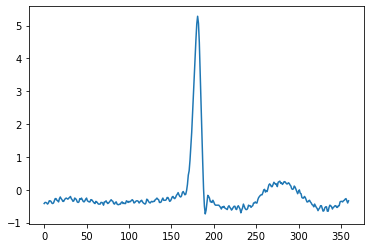

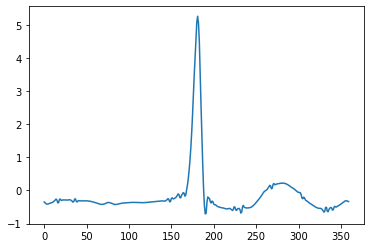

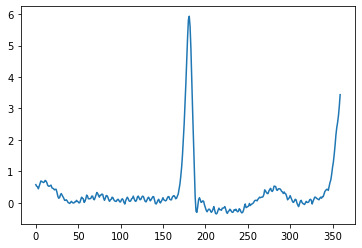

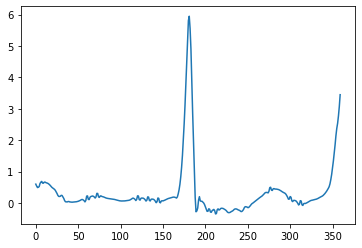

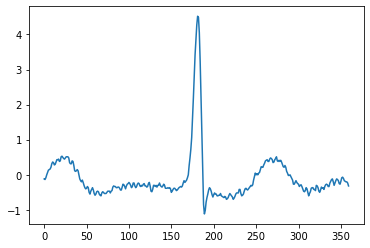

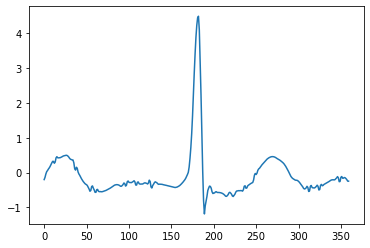

In [119]:
df_noise_ex = load_csv(root[:-5], 'dataframe.csv')
_ = df_noise_ex.pop('Type')
_ = df_noise_ex.pop('Sample#')
_ = df_noise_ex.pop('Person')

samp = 14
quick_plot(df_noise_ex.iloc[samp])
quick_plot_ar(wave2(df_noise_ex.iloc[samp]))

samp = 742
quick_plot(df_noise_ex.iloc[samp])
quick_plot_ar(wave2(df_noise_ex.iloc[samp]))

samp = 467
quick_plot(df_noise_ex.iloc[samp])
quick_plot_ar(wave2(df_noise_ex.iloc[samp]))

# Exercise 5

In [42]:
# Model 1 == Random Forest
def RF(depth=7, estimators=10, min_samples_split=3):
    model = RandomForest(max_depth=depth, min_samples_split=min_samples_split, n_estimators=estimators, criterion='entropy').fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    return y_train_pred, y_val_pred, model

# Metrics method to calculate f1, accuracy, precision, recall and classification report by class
def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    prec = precision_score(y_true, y_pred, average='weighted')
    classification = classification_report(y_true, y_pred)
    print(f'F1 Score: {f1}')
    print(f'Accuracy Score: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print(f'Classification Report:\n {classification}')
    print()

In [108]:

'''
Random Forest Metrics
'''
y_train_pred, y_val_pred, model_RF = RF(depth=20, estimators=25, min_samples_split=2)
print('Train Metrics:')
metrics(y_train, y_train_pred)
print('\nValidation Metrics:')
metrics(y_val, y_val_pred)
print('\nTest Metrics:')
y_test_pred = model_RF.predict(X_test)
metrics(y_test, y_test_pred)

print()

Train Metrics:
F1 Score: 0.9993404035678285
Accuracy Score: 0.9993402111324377
Precision: 0.999341512360094
Recall: 0.9993402111324377
Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00     42195
           L       1.00      1.00      1.00     46447
           N       1.00      1.00      1.00     41607
           R       1.00      1.00      1.00     44853
           U       1.00      1.00      1.00     46340
           V       1.00      1.00      1.00     45310

    accuracy                           1.00    266752
   macro avg       1.00      1.00      1.00    266752
weighted avg       1.00      1.00      1.00    266752



Validation Metrics:
F1 Score: 0.9752985926440904
Accuracy Score: 0.9753320049425044
Precision: 0.9753442511261341
Recall: 0.9753320049425044
Classification Report:
               precision    recall  f1-score   support

           A       0.97      0.99      0.98     14306
           L       0.9

# Exercise 6

In [104]:
def build_model_nn(input_len, num_classes):
  model = Sequential()
  model.add(L.Dense(256, activation='relu', input_shape=(input_len,)))
  model.add(L.Dense(512, activation='relu'))
  model.add(L.Dense(512, activation='relu'))
  model.add(L.Dense(512, activation='relu'))
  model.add(L.Dropout(0.6))
  model.add(L.Dense(256, activation='relu'))
  model.add(L.Dense(num_classes, activation=tensorflow.nn.softmax))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def NN(input_len, epochs=5):
  #ohe y
  lb = LabelBinarizer()
  y_train_ohe = lb.fit_transform(y_train)
  y_val_ohe = lb.transform(y_val)
  n_classes = len(lb.classes_)
  
  # Apply a feed-forward neural network along with hyper-parameter tuning for the same.
  model = build_model_nn(input_len, n_classes)  

  model_name_loss = root[:-5] +'best_model_loss_v3.h5'
  chkpoint = ModelCheckpoint(filepath=model_name_loss, 
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True,
                              mode='min')

  callbacks = [chkpoint]

  bs = 32
  history_model = model.fit(X_train, y_train_ohe, batch_size=bs,epochs=epochs, validation_data=(X_val,y_val_ohe),callbacks=callbacks)
  
  return model, history_model, lb

In [105]:
X_train, y_train, X_val, y_val, X_test, y_test = VAE_imbalance()

Train Class A VAE... --  Finished -- 
Train Class V VAE... --  Finished -- 
Train Class U VAE... --  Finished -- 
Train Class L VAE... --  Finished -- 
Train Class R VAE... --  Finished -- 
Generate Training Samples from VAE
Class A: ...(55605, 10)
Class V: ...(55605, 10)
Class U: ...(55605, 10)
Class L: ...(55605, 10)
Class R: ...(55605, 10)
Sample generation completed


Classes have the below balance: 
class N: 41607 samples. ( 15.598%)
class L: 46447 samples. ( 17.412%)
class R: 44853 samples. ( 16.814%)
class A: 42195 samples. ( 15.818%)
class V: 45310 samples. ( 16.986%)
class U: 46340 samples. ( 17.372%)


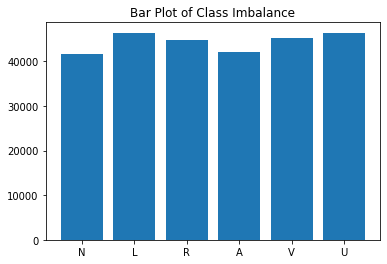

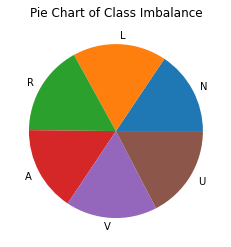

In [107]:
'''
Class balance post vae sample generation
'''
x_temp = pd.DataFrame(X_train)

x_temp['Type'] = y_train
_, _ = class_imbalance_checker(x_temp, print_out=True)

In [109]:
# Train the Feed-Forward NN
model_nn, history, lb_nn = NN(360, epochs=10)

Epoch 1/10
8333/8336 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9575
Epoch 1: val_loss improved from inf to 0.10471, saving model to /content/drive/My Drive/UW/AI_healthcare/Mini-project-1/best_model_loss_v3.h5
8336/8336 [==============================] - 26s 3ms/step - loss: 0.1456 - accuracy: 0.9575 - val_loss: 0.1047 - val_accuracy: 0.9729
Epoch 2/10
8334/8336 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9793
Epoch 2: val_loss improved from 0.10471 to 0.04926, saving model to /content/drive/My Drive/UW/AI_healthcare/Mini-project-1/best_model_loss_v3.h5
8336/8336 [==============================] - 25s 3ms/step - loss: 0.0808 - accuracy: 0.9793 - val_loss: 0.0493 - val_accuracy: 0.9875
Epoch 3/10
8332/8336 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9831
Epoch 3: val_loss did not improve from 0.04926
8336/8336 [==============================] - 23s 3ms/step - loss: 0.0700 - accuracy: 0.9831 - val_loss:

In [120]:
model = build_model_nn(360, len(lb_nn.classes_))  
model.load_weights(root[:-5] +'best_model_loss_v3.h5')

y_val_pred = model.predict(X_val)
y_val_pred = lb_nn.inverse_transform(y_val_pred)
metrics(y_val, y_val_pred)

y_test_pred = model.predict(X_test)
y_test_pred = lb_nn.inverse_transform(y_test_pred)
metrics(y_test, y_test_pred)

F1 Score: 0.9874657467159461
Accuracy Score: 0.9874767624369664
Precision: 0.9874720539923709
Recall: 0.9874767624369664
Classification Report:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     14306
           L       1.00      1.00      1.00     15590
           N       0.98      0.97      0.98     13977
           R       1.00      1.00      1.00     15232
           U       0.98      0.97      0.98     15409
           V       0.98      0.99      0.98     15319

    accuracy                           0.99     89833
   macro avg       0.99      0.99      0.99     89833
weighted avg       0.99      0.99      0.99     89833


F1 Score: 0.9643556205197905
Accuracy Score: 0.9639530174159578
Precision: 0.9651449472285641
Recall: 0.9639530174159578
Classification Report:
               precision    recall  f1-score   support

           A       0.72      0.73      0.73       260
           L       0.98      0.99      0.99      1639
   

In [66]:
print(X_train.shape)

(199393, 360)


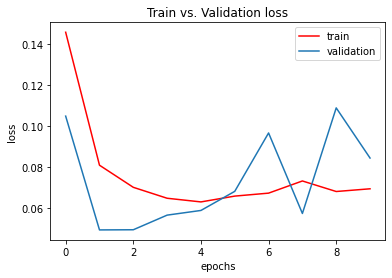

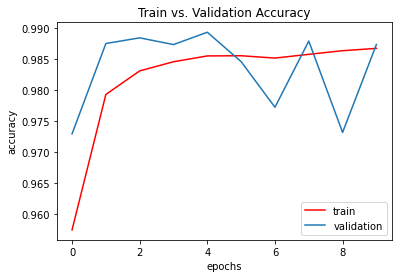

In [126]:
def plotting_ffn(history):
  # Plotting the curves of training, validation and test sets losses and
  # accuracy scores with number of epochs on the x-axis.

  x = np.arange(0, len(history.history['loss']))
  plt.plot(x,history.history['loss'], color='red', label='train')
  plt.plot(x,history.history['val_loss'], label='validation')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Train vs. Validation loss')
  plt.legend(loc='upper right')
  plt.show()

  x = np.arange(0, len(history.history['accuracy']))
  plt.plot(x,history.history['accuracy'], color='red', label='train')
  plt.plot(x,history.history['val_accuracy'], label='validation')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Train vs. Validation Accuracy')
  plt.legend(loc='lower right')
  plt.show()

plotting_ffn(history)

# Exercise 7

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

In [135]:
class CNN(nn.Module):
    def __init__(self,size=86):
        super(CNN, self).__init__()
        self.C1 = nn.Conv1d(in_channels=1,out_channels=64,kernel_size=5)
        self.C2 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=5)
        self.S1 = nn.MaxPool1d(2)
        self.C3 = nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3)
        self.C4 = nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3)
        self.S2 = nn.MaxPool1d(2)
        self.L1 = nn.Linear(in_features=size*128,out_features=256)
        self.L2 = nn.Linear(in_features=256,out_features=128)
        self.L3 = nn.Linear(in_features=128,out_features=6)
        self.ReLU = nn.ReLU()
        self.softmax =nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
                
    def forward(self, x):
        x = self.ReLU(self.C1(x))
        x = self.dropout(x)
        x = self.ReLU(self.C2(x))
        x = self.S1(x)
        x = self.ReLU(self.C3(x))
        x = self.dropout(x)
        x = self.ReLU(self.C4(x))
        x = self.S2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.ReLU(self.L1(x))
        x = (self.L2(x))
        x = (self.L3(x))
        
        return x


import torch.optim as optim

class cnnModel:
    def __init__(self,model,data_train,data_val, input_dim=360):
        self.data=data_train
        self.data_val=data_val
        self.model=model
        self.criterion=nn.CrossEntropyLoss()
        self.loss_train=[]
        self.loss_val=[]
        self.accuracy_train=[]
        self.accuracy_val=[]
        self.input_dim=input_dim

        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.7)#Adam(model.parameters(), lr= 1e-4)

    def train(self,epochs):
        self.model.train()
        self.model = self.model.to(device=device) 

        for epoch in range(epochs): 
            loss_ep = 0
            num_correct=0
            num_samples=0
            for batch_idx, (data, targets) in enumerate(self.data):
                data=torch.reshape(data,(32,1,self.input_dim)).float().to(device=device)
                #data=data.float().to(device=device)
                targets = targets
                ## Forward Pass
                self.optimizer.zero_grad()
                scores = self.model(data)
                _, predictions = scores.max(1)
                num_correct += (predictions == targets.reshape(-1).to(device=device)).sum()
                num_samples += predictions.size(0)
                loss = self.criterion(scores,targets.reshape(-1).to(device=device))
                loss.backward()
                self.optimizer.step()
                loss_ep += loss.item()
            
            self.loss_train.append(loss_ep/len(self.data))
            self.accuracy_train.append(float(num_correct) / float(num_samples) * 100)
            print(f"Loss in epoch {epoch} :::: {loss_ep/len(self.data)} and accuracy is {float(num_correct) / float(num_samples) * 100:.2f}")

            loss_ep = 0
            with torch.no_grad():
                num_correct = 0
                num_samples = 0
                for batch_idx, (val,targetsV) in enumerate(self.data_val):
                    val = torch.reshape(val,(32,1,self.input_dim)).to(device=device)
                    #val = val.float().to(device=device)
                    targetsV = targetsV.reshape(-1).to(device=device)
                    ## Forward Pass
                    scores = self.model(val.float())
                    
                    #print('target=',targetsV)
                    _, predictions = scores.max(1)
                    #print('predictions=',predictions)
                    num_correct += (predictions == targetsV).sum()
                    num_samples += predictions.size(0)
                    loss = self.criterion(scores,targetsV.reshape(-1).to(device=device))
                    loss_ep += loss.item()
                self.accuracy_val.append(float(num_correct) / float(num_samples) * 100)
                self.loss_val.append(loss_ep/len(self.data))
                print(f"Got in validation {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")


    def evaluation(self,x):
        with torch.no_grad():
            output=[]
            true=[]
            for batch_idx, (val,targetsV) in enumerate(x):
                val = torch.reshape(val,(val.numpy().shape[0],1,self.input_dim)).to(device=device)
                _,prediction = self.model(val.float()).max(1)
                output.append(prediction.cpu().detach().numpy())
                true.append(targetsV.cpu().numpy())
        return output,true

    def plot_loss(self):
        plt.figure(1)
        plt.plot(self.loss_train)
        plt.plot(self.loss_val)
        plt.legend(['Train','validation'])

        plt.figure(2)
        plt.plot(self.accuracy_train)
        plt.plot(self.accuracy_val)
        plt.legend(['Train','validation'])


In [150]:
X_train, y_train, X_val, y_val, X_test, y_test = VAE_imbalance()

Train Class A VAE... --  Finished -- 
Train Class V VAE... --  Finished -- 
Train Class U VAE... --  Finished -- 
Train Class L VAE... --  Finished -- 
Train Class R VAE... --  Finished -- 
Generate Training Samples from VAE
Class A: ...(55605, 10)
Class V: ...(55605, 10)
Class U: ...(55605, 10)
Class L: ...(55605, 10)
Class R: ...(55605, 10)
Sample generation completed


In [151]:
# VAE

le = LBE()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)
y_test_le = le.transform(y_test)

dataset = Dataset(X_train,y_train_le)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

val_shape=math.floor(X_val.shape[0]/32)*32

dataset_val = Dataset(X_val[:val_shape],y_val_le[:val_shape])
data_loader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = Dataset(X_test,y_test_le)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [87]:
# AE

# Load AE data
X_train = load_csv(root[:-5], 'modded/X_train_more_samples.csv') # save the df
X_val = load_csv(root[:-5], 'modded/X_val.csv') # save the df
X_test = load_csv(root[:-5], 'modded/X_test.csv') # save the df

y_train = X_train.pop('Type')
y_val = X_val.pop('Type')
y_test  = X_test.pop('Type')

X_train.drop(index=X_train.index[-1], axis=0, inplace=True)
y_train.drop(index=y_train.index[-1], axis=0, inplace=True)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

le = LBE()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)
y_test_le = le.transform(y_test)


dataset = Dataset(X_train,y_train_le)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

val_shape=math.floor(X_val.shape[0]/32)*32

dataset_val = Dataset(X_val[:val_shape],y_val_le[:val_shape])
data_loader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

dataset_test = Dataset(X_test,y_test_le)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [124]:
cnn_model = CNN()
cnn_model_train = cnnModel(cnn_model,data_loader,data_loader_val)

Loss in epoch 0 :::: 0.41585252805482936 and accuracy is 85.42
Got in validation 85960 / 89824 with accuracy 95.70
Loss in epoch 1 :::: 0.1081539689310274 and accuracy is 96.71
Got in validation 87352 / 89824 with accuracy 97.25
Loss in epoch 2 :::: 0.07337408312469226 and accuracy is 97.79
Got in validation 88274 / 89824 with accuracy 98.27
Loss in epoch 3 :::: 0.05536653040170487 and accuracy is 98.44
Got in validation 88536 / 89824 with accuracy 98.57
Loss in epoch 4 :::: 0.044933254199473846 and accuracy is 98.76
Got in validation 88752 / 89824 with accuracy 98.81
Loss in epoch 5 :::: 0.03790468242256938 and accuracy is 98.97
Got in validation 88931 / 89824 with accuracy 99.01
Loss in epoch 6 :::: 0.03332650641534337 and accuracy is 99.10
Got in validation 88946 / 89824 with accuracy 99.02
Loss in epoch 7 :::: 0.02923512945618521 and accuracy is 99.20
Got in validation 88887 / 89824 with accuracy 98.96


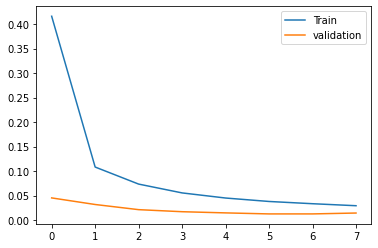

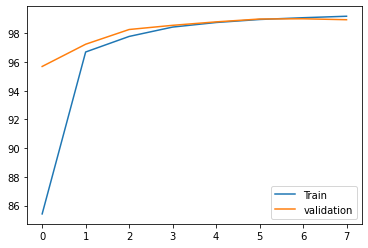

In [125]:
cnn_model_train.train(8)

cnn_model_train.plot_loss()

In [152]:
# get predictions for validation set, reshape and inverse transform
y_pred_val, true_val = cnn_model_train.evaluation(data_loader_val)
y_pred_val = le.inverse_transform(np.array(y_pred_val).reshape(-1))
true_val = le.inverse_transform(np.array(true_val).reshape(-1))
# metrics for validation set
metrics(y_pred_val, true_val)

# get preds for test set
ypred_test,true_test=cnn_model_train.evaluation(data_loader_test)
# reformat preds and ground truths
y_pred_test=[]
for i in range(0,len(ypred_test)):
    y_pred_test.extend(np.array(ypred_test)[i].reshape(-1))
y_test=[]
for i in range(0,len(true_test)):
    y_test.extend(np.array(true_test)[i].reshape(-1))
# inverse transform the labels
y_pred_test = le.inverse_transform(np.array(y_pred_test).reshape(-1))
y_test = le.inverse_transform(np.array(y_test).reshape(-1))
# metrics for test set
metrics(y_pred_test, y_test)

F1 Score: 0.9701952208392474
Accuracy Score: 0.9701972746704667
Precision: 0.9703599045520619
Recall: 0.9701972746704667
Classification Report:
               precision    recall  f1-score   support

           A       0.98      0.97      0.97     14405
           L       0.99      1.00      0.99     15421
           N       0.98      0.94      0.96     14527
           R       1.00      1.00      1.00     15211
           U       0.94      0.95      0.94     15147
           V       0.95      0.96      0.96     15113

    accuracy                           0.97     89824
   macro avg       0.97      0.97      0.97     89824
weighted avg       0.97      0.97      0.97     89824


F1 Score: 0.9663832774491626
Accuracy Score: 0.9679526123936817
Precision: 0.9661271267045699
Recall: 0.9679526123936817
Classification Report:
               precision    recall  f1-score   support

           A       0.74      0.48      0.58       405
           L       0.99      0.98      0.99      1643
   

In [149]:
'''
Testing metrics on all the data
'''
df = load_csv(root[:-5], 'dataframe.csv')
X=df.drop(['Sample#','Person','Type'],axis=1)
y=df['Type']

for i in range(X.shape[0]):
  X.iloc[i] = wave2(X.iloc[i].values) # denoise each signal

X = X.to_numpy()

le = LBE()
y = le.fit_transform(y)

dataset_all = Dataset(X,y)
data_loader_all = DataLoader(dataset_all, batch_size=32, shuffle=True)

ypred_all,true_all=cnn_model_train.evaluation(data_loader_all)

out_all=[]
for i in range(0,len(ypred_all)):
    out_all.extend(np.array(ypred_all)[i].reshape(-1))

out_true_all=[]
for i in range(0,len(true_all)):
    out_true_all.extend(np.array(true_all)[i].reshape(-1))

out_all = le.inverse_transform(np.array(out_all).reshape(-1))
out_true_all = le.inverse_transform(np.array(out_true_all).reshape(-1))
# metrics for test set
metrics(out_all, out_true_all)

F1 Score: 0.970181808167838
Accuracy Score: 0.9714378712669868
Precision: 0.9698985501721794
Recall: 0.9714378712669868
Classification Report:
               precision    recall  f1-score   support

           A       0.74      0.49      0.59      1754
           L       0.99      0.99      0.99      8045
           N       0.98      0.99      0.98     68783
           R       0.98      0.99      0.99      5574
           U       0.92      0.91      0.92      7781
           V       0.96      0.95      0.95      6375

    accuracy                           0.97     98312
   macro avg       0.93      0.89      0.90     98312
weighted avg       0.97      0.97      0.97     98312




# Exercise 9

In [129]:
# Running with some other data.
# Call previously defined functions for the new set of input feature values.

# call data preprocessor function
data,annotations,filename=preprocessor(root)

# find best 2nd feature 
MLII=0
V1=0
V2=0
V3=0
V4=0
V5=0
for i in range(0,len(data)):
    if('MLII' in data[i].columns):
        MLII+=1
    if('V1' in data[i].columns):
        V1+=1
    if('V2' in data[i].columns):
        V2+=1
    if('V3' in data[i].columns):
        V3+=1
    if('V4' in data[i].columns):
        V4+=1
    if('V5' in data[i].columns):
        V5+=1
print(f'MLII:{MLII}')  
print(f'V1:{V1}')  
print(f'V2:{V2}')  
print(f'V3:{V3}')  
print(f'V4:{V4}')  
print(f'V5:{V5}')    

MLII:42
V1:36
V2:4
V3:0
V4:1
V5:5


In [130]:
'''
Preprocess the data and save it to a df on drive
'''
df=pd.DataFrame()

for i in range(0,len(data)):
    if('MLII' in data[i].columns):
        df_person = create_features(data[i],annotations[i])
        df_person['Person']=filename[i].split('.')[0]
        if(i==0):
            df=df_person
        else:
            df=pd.concat([df,df_person],axis=0)
    else:
        print(f'MLII not present in {filename[i]}')

    if('MLII' in data[i].columns and 'V1' in data[i].columns):
        df_person_2f = create_features(data[i],annotations[i],feature_no=720)
        df_person_2f['Person']=filename[i].split('.')[0]
        try:
            df_2f=pd.concat([df_2f,df_person_2f],axis=0)
        except:
            df_2f=df_person_2f        
    else:
        print(f'MLII and V1 not present in {filename[i]}')

df_2f.to_csv(root[:-5] + 'dataframe2.csv', index=False) # save the df

MLII and V1 not present in 124.csv
MLII and V1 not present in 123.csv
MLII and V1 not present in 114.csv
MLII and V1 not present in 117.csv
MLII not present in 102.csv
MLII and V1 not present in 102.csv
MLII and V1 not present in 103.csv
MLII and V1 not present in 100.csv
MLII not present in 104.csv
MLII and V1 not present in 104.csv


In [137]:
X_train2, y_train2, X_val2, y_val2, X_test2, y_test2 = VAE_imbalance(file_name='dataframe2.csv', input_dim=720)

Train Class A VAE... --  Finished -- 
Train Class V VAE... --  Finished -- 
Train Class U VAE... --  Finished -- 
Train Class L VAE... --  Finished -- 
Train Class R VAE... --  Finished -- 
Generate Training Samples from VAE
Class A: ...(48257, 10)
Class V: ...(48257, 10)
Class U: ...(48257, 10)
Class L: ...(48257, 10)
Class R: ...(48257, 10)
Sample generation completed


In [138]:
le = LBE()
y_train_le2 = le.fit_transform(y_train2)
y_val_le2 = le.transform(y_val2)
y_test_le2 = le.transform(y_test2)

dataset2 = Dataset(X_train2,y_train_le2)
data_loader2 = DataLoader(dataset2, batch_size=32, shuffle=True)

val_shape2=math.floor(X_val2.shape[0]/32)*32

dataset_val2 = Dataset(X_val2[:val_shape2],y_val_le2[:val_shape2])
data_loader_val2 = DataLoader(dataset_val2, batch_size=32, shuffle=True)

dataset_test2 = Dataset(X_test2,y_test_le2)
data_loader_test2 = DataLoader(dataset_test2, batch_size=32, shuffle=False)

In [139]:
model_2f = CNN(size=176)
model_2f=cnnModel(model_2f,data_loader2,data_loader_val2,input_dim=720)
model_2f.train(10)

Loss in epoch 0 :::: 0.28355189846163714 and accuracy is 90.31
Got in validation 42915 / 44320 with accuracy 96.83
Loss in epoch 1 :::: 0.05578288060493419 and accuracy is 98.51
Got in validation 43851 / 44320 with accuracy 98.94
Loss in epoch 2 :::: 0.03773571562482744 and accuracy is 99.03
Got in validation 43936 / 44320 with accuracy 99.13
Loss in epoch 3 :::: 0.029520292185628367 and accuracy is 99.24
Got in validation 44027 / 44320 with accuracy 99.34
Loss in epoch 4 :::: 0.023653455784774284 and accuracy is 99.39
Got in validation 44059 / 44320 with accuracy 99.41
Loss in epoch 5 :::: 0.02025177814664381 and accuracy is 99.49
Got in validation 44044 / 44320 with accuracy 99.38
Loss in epoch 6 :::: 0.0175975923690716 and accuracy is 99.55
Got in validation 44104 / 44320 with accuracy 99.51
Loss in epoch 7 :::: 0.015876947181989474 and accuracy is 99.59
Got in validation 44022 / 44320 with accuracy 99.33
Loss in epoch 8 :::: 0.014944204151346563 and accuracy is 99.60
Got in validat

In [142]:
# get preds for test set
ypred_test2,true_test2=model_2f.evaluation(data_loader_test2)
# reformat preds and ground truths
y_pred_test2=[]
for i in range(0,len(ypred_test2)):
    y_pred_test2.extend(np.array(ypred_test2)[i].reshape(-1))
y_test2=[]
for i in range(0,len(true_test2)):
    y_test2.extend(np.array(true_test2)[i].reshape(-1))
# inverse transform the labels
y_pred_test2 = le.inverse_transform(np.array(y_pred_test2).reshape(-1))
y_test2 = le.inverse_transform(np.array(y_test2).reshape(-1))
# metrics for test set
metrics(y_pred_test2, y_test2)

F1 Score: 0.9785345437985364
Accuracy Score: 0.9783906738697754
Precision: 0.9787307387496609
Recall: 0.9783906738697754
Classification Report:
               precision    recall  f1-score   support

           A       0.74      0.79      0.77       229
           L       0.99      0.99      0.99      1645
           N       0.99      0.99      0.99     12093
           R       1.00      0.99      1.00       845
           U       0.92      0.94      0.93      1490
           V       0.96      0.95      0.95      1283

    accuracy                           0.98     17585
   macro avg       0.93      0.94      0.94     17585
weighted avg       0.98      0.98      0.98     17585




# Exercise 10

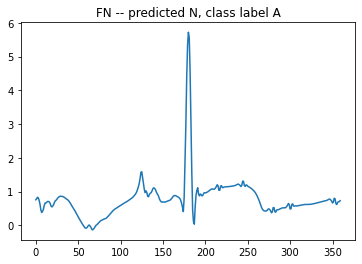

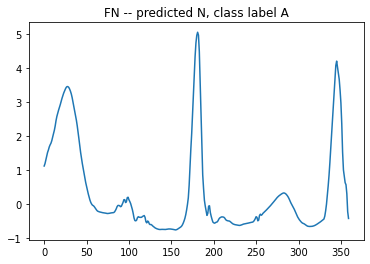

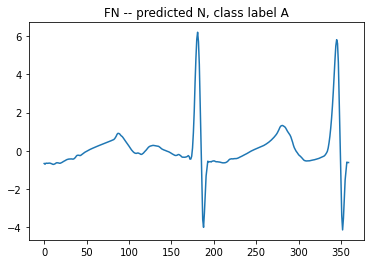

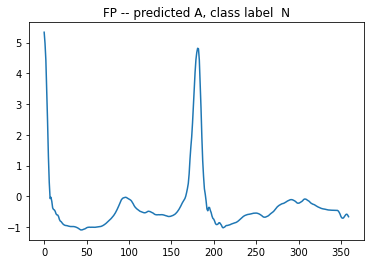

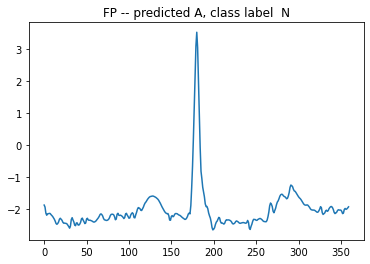

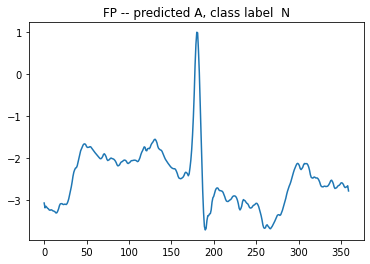

In [160]:
def plot_final(X, preds, ground_truth):
  # plot examples or time-series snippets of
  # mis-classified arrhythmia (False positives) and also false negatives.
  
  FP, FN = 0, 0

  for i in range(len(preds)):
    if (preds[i] == 'N') and (ground_truth[i] == 'A') and FN<3:
      quick_plot_ar(X[i], title='FN -- predicted N, class label A')
      FN+=1
    elif (y_pred_test[i] == 'A') and (ground_truth[i] == 'N') and FP<3:
      quick_plot_ar(X[i], title='FP -- predicted A, class label  N')
      FP+=1
    
    if FP > 2  and FN > 2:
      return

  return

plot_final(X_test, y_pred_test, y_test)

# Kaggle Data

In [92]:
'''
Function to parse the kaggle data based on the indices given in the kaggle data file patient_number.csv
'''
def norm_patient_kaggle(df_in):
  # split by patient
  p1 = df_kaggle.iloc[0:1570]
  p2 = df_kaggle.iloc[1570:3349]
  p3 = df_kaggle.iloc[3349:6415]
  p4 = df_kaggle.iloc[6415:]

  # Convert to numpy and get original shape for each
  p1 = p1.to_numpy()
  p1_shape = p1.shape

  p2 = p2.to_numpy()
  p2_shape = p2.shape

  p3 = p3.to_numpy()
  p3_shape = p3.shape

  p4 = p4.to_numpy()
  p4_shape = p4.shape

  # Use standard scaler normalize function from preprocessing on the flattened array and then reshape as original shape
  p1_norm = np.reshape(normalizer(p1.flatten()[:, np.newaxis]), p1_shape)

  p2_norm = np.reshape(normalizer(p2.flatten()[:, np.newaxis]), p2_shape)

  p3_norm = np.reshape(normalizer(p3.flatten()[:, np.newaxis]), p3_shape)

  p4_norm = np.reshape(normalizer(p4.flatten()[:, np.newaxis]), p4_shape)

  # concat them all together
  patients = np.append(p1_norm, p2_norm , axis=0)
  patients = np.append(patients, p3_norm , axis=0)
  patients = np.append(patients, p4_norm , axis=0)

  return pd.DataFrame(patients)

In [101]:
# Load the kaggle data, remove Id and get stats for normalizer
df_kaggle = load_csv(root[:-5], 'kaggle_data.csv')
_ids = df_kaggle.pop('Id')

# normalize kaggle data
df_norm = norm_patient_kaggle(df_kaggle)

#for i in range(df_norm.shape[0]):
#  df_norm.iloc[i] = wave2(df_norm.iloc[i].values)

# declare model to test
model_ = 'cnn'

if model == 'nn':
  print('using nn to predict kaggle')
  # load nn weights
  model = build_model_nn(360, len(lb_nn.classes_))  
  model.load_weights(root[:-5] +'best_model_loss_v3.h5')
  # generate kaggle preds
  y_kaggle_pred = model.predict(df_norm)
  y_kaggle_pred = lb_nn.inverse_transform(y_kaggle_pred)

elif model =='RF':
  y_kaggle_pred = model_RF.predict(df_norm)

else:
  # generate dummy y for kaggle so that we can build data loader
  y_kaggle_dummy = (np.full((df_norm.shape[0],1),'A').tolist())
  y_kaggle_dummy = le.transform(y_kaggle_dummy)

  kaggle = df_norm.to_numpy()

  # build dataloader from kaggle data
  dataset_kaggle = Dataset(kaggle, y_kaggle_dummy)
  data_loader_kaggle = DataLoader(dataset_kaggle, batch_size=32, shuffle=False)

  y_pred, _ = cnn_model_train.evaluation(data_loader_kaggle)

  y_kaggle_pred = []
  for i in range(0,len(y_pred)):
      y_kaggle_pred.extend(np.array(y_pred)[i].reshape(-1))

  y_kaggle_pred = le.inverse_transform(np.array(y_kaggle_pred).reshape(-1))

counts = [0,0,0,0,0,0]
for p in y_kaggle_pred:
  if p == 'A': counts[0] += 1
  elif p == 'L': counts[1] += 1
  elif p == 'N': counts[2] += 1
  elif p == 'R': counts[3] += 1
  elif p == 'U': counts[4] += 1
  elif p == 'V': counts[5] += 1

print(f'A: {counts[0]}')
print(f'L: {counts[1]}')
print(f'N: {counts[2]}')
print(f'R: {counts[3]}')
print(f'U: {counts[4]}')
print(f'V: {counts[5]}')

# format data for export
out_data = {
    'Id' : (_ids),
    'heartbeat_type' : (y_kaggle_pred)
}
out_df = pd.DataFrame(out_data)

if model_ == 'nn':
  # export
  print('exporting as preds_test_nn.csv')
  out_df.to_csv(root[:-5] + 'preds_test_nn.csv', index=False)
elif model == 'RF':
  out_df.to_csv(root[:-5] + 'preds_test_rf.csv', index=False)
else:
  out_df.to_csv(root[:-5] + 'preds_test_cnn.csv', index=False)


print('File Exported!')

A: 44
L: 2
N: 6224
R: 1079
U: 11
V: 1757
File Exported!
